## DDSM

In [2]:
!pip install torch torchvision torchaudio

   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.5/212.5 MB 932.9 kB/s eta 0:03:48
   ---------------------------------------- 0.8/212.5 MB 987.4 kB/s eta 0:03:35
   ---------------------------------------- 1.0/212.5 MB 1.0 MB/s eta 0:03:31
   ---------------------------------------- 1.3/212.5 MB 1.0 MB/s eta 0:03:25
   ---------------------------------------- 1.3/212.5 MB 1.0 MB/s eta 0:03:25
   ---------------------------------------- 1.6/212.5 MB 1.0 MB/s eta 0:03:24
   ---------------------------------------- 1.6/212.5 MB 1.0 MB/s eta 0:03:24
   ---------------------------------------- 1.8/212.5 MB 915.0 kB/s eta 0:03:51
   ---------------------------------------- 2.1/212.5 MB 910.2 kB/s eta 0:03:52
   ---------------------------------------- 2.4/212.5 MB 932.1 kB/s eta 0:03:

In [7]:
! pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [9]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [10]:
!pip install numpy pillow pandas matplotlib 

Defaulting to user installation because normal site-packages is not writeable


In [11]:
!pip install deap 

Defaulting to user installation because normal site-packages is not writeable


In [12]:
!pip install opencv-python 

Defaulting to user installation because normal site-packages is not writeable


In [14]:
!pip install opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable


In [15]:
! pip install tensorflow keras

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras import regularizers
from keras import backend as K  # Pour clear_session
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    roc_curve, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from deap import base, creator, tools, algorithms
import optuna

In [10]:
# Definition of DDSM and INbreast directories
ddsm_benign_dir = 'C:\\Users\\amal\\Desktop\\Datasetsofmammography\\DDSM\\Benign'
ddsm_malignant_dir = 'C:\\Users\\amal\\Desktop\\Datasetsofmammography\\DDSM\\Malignant'

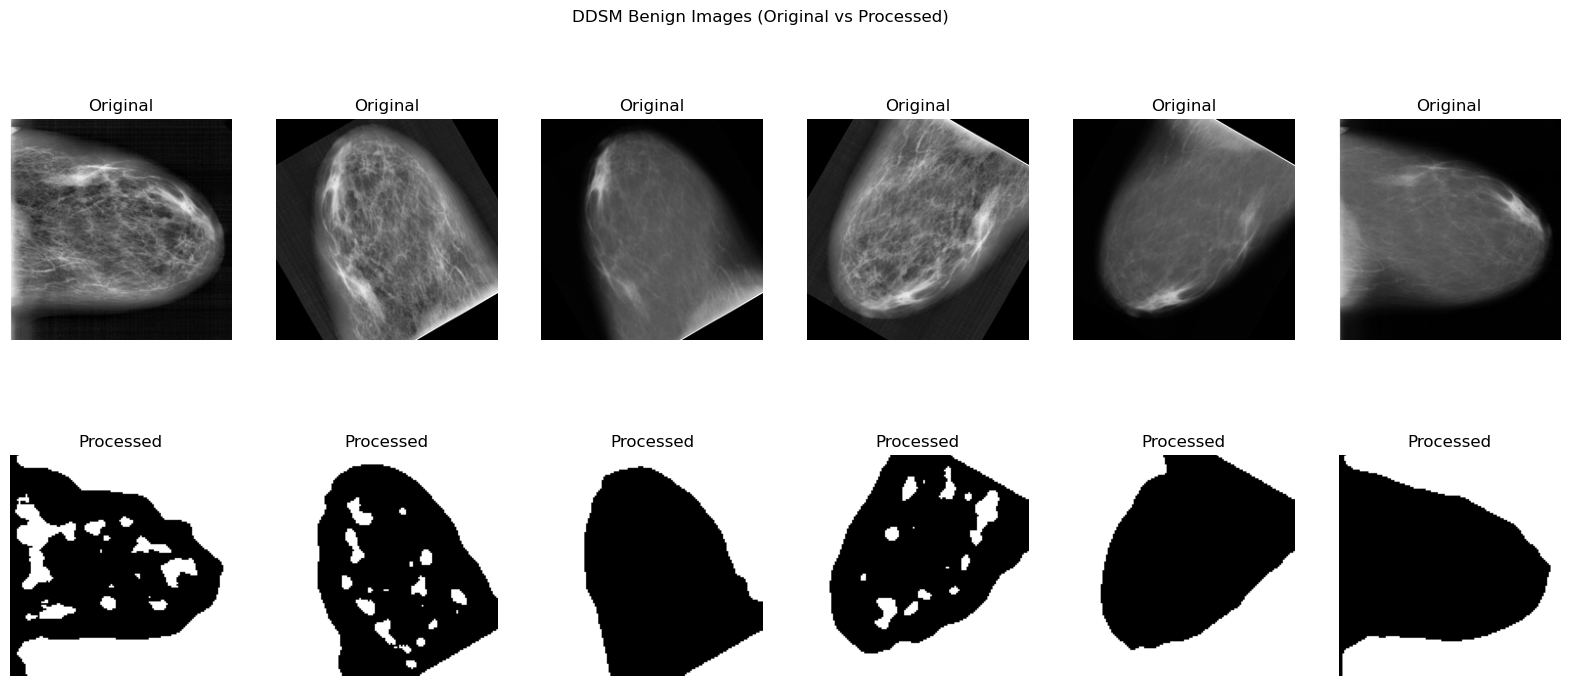

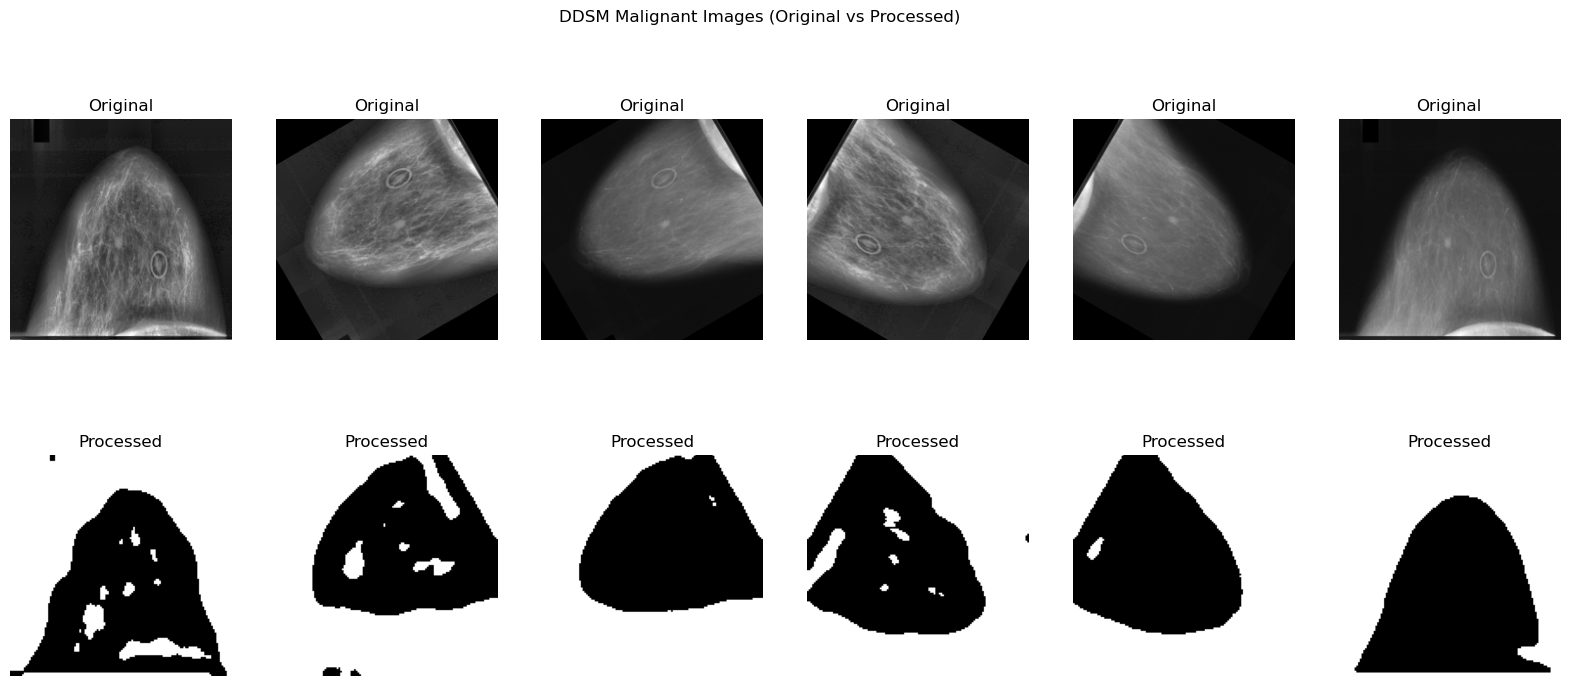

Combined Images Shape: (13128, 128, 128)
Combined Labels Shape: (13128,)

DDSM Benign: 5970
DDSM Malignant: 7158

Total images: 13128
Image shape: (128, 128, 1)

Class distribution:
 [5970 7158]


In [19]:
# Function to load PNG images
def load_png_images(folder):                                   # Function Declaration
    images = []                                                # Initialize the images list
    for filename in os.listdir(folder):                        # Iterate over files in the directory
        img_path = os.path.join(folder, filename)              # Create the full file path
        if img_path.endswith('.png'):                          # Filter for PNG files (Yes / No)
            with Image.open(img_path) as img:                  # Open the PNG file
                for frame in range(img.n_frames):              # Iterate over GIF frames
                    img.seek(frame)                            # Select the current frame
                    frame_image = np.array(img.convert('L'))   # Convert to grayscale
                    images.append(frame_image)                 # Add the image to the list
    return images                                              # Return the list of images
    
# Function to resize images to a smaller size (e.g., 128x128)
def resize_images(images, target_size=(128, 128)):
    resized_images = []
    for img in images:
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA).astype(np.uint8)
        resized_images.append(img_resized)
    return np.array(resized_images)

# Function to preprocess images (with resizing)
def preprocess_images(images, target_size=(128, 128)):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    preprocessed_images = []
    
    for img in images:
        if img.ndim > 2:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Resize image to the target size (e.g., 128x128)
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA).astype(np.uint8)
        img_clahe = clahe.apply(img_resized)
        img_bright = cv2.convertScaleAbs(img_clahe, alpha=1, beta=30)
        img_denoised = cv2.medianBlur(img_bright, 5)
        _, img_segmented = cv2.threshold(img_denoised, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        img_normalized = img_segmented / 255.0
        
        preprocessed_images.append(img_normalized)
    
    return np.array(preprocessed_images)

# Function to load and preprocess images
def load_and_preprocess_images(folder, target_size=(128, 128)):
    images = load_png_images(folder)
    preprocessed_images = preprocess_images(images, target_size)
    return images, preprocessed_images

# Function to load and preprocess images
def display_images(images, processed_images=None, title="Images"):                # Function Declaration
    if len(images) == 0:                                                          
        print("Aucune image à afficher.") 
        return
    
    if processed_images is None:                                                  # Condition to display the original images
        fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
        fig.suptitle(title)
        for i, img in enumerate(images):
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
        plt.show()
    else:                                                                         #Condition to display the original and processed images
        fig, axes = plt.subplots(2, len(images), figsize=(20, 8)) 
        fig.suptitle(title)
        for i in range(len(images)):
            axes[0, i].imshow(images[i], cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Original')

            axes[1, i].imshow(processed_images[i], cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title('Processed')
        plt.show()
        
# Load and preprocess images (benign and malignant)
ddsm_benign_images, ddsm_benign_preprocessed = load_and_preprocess_images(ddsm_benign_dir, target_size=(128, 128))
ddsm_malignant_images, ddsm_malignant_preprocessed = load_and_preprocess_images(ddsm_malignant_dir, target_size=(128, 128))

# Display the first 6 original and preprocessed images for benign and malignant classes
display_images(ddsm_benign_images[:6], ddsm_benign_preprocessed[:6], "DDSM Benign Images (Original vs Processed)")
display_images(ddsm_malignant_images[:6], ddsm_malignant_preprocessed[:6], "DDSM Malignant Images (Original vs Processed)")

# Ensure both are numpy arrays before concatenation
ddsm_benign_preprocessed_array = np.array(ddsm_benign_preprocessed)
ddsm_malignant_preprocessed_array = np.array(ddsm_malignant_preprocessed)

# Now concatenate
all_images = np.concatenate((ddsm_benign_preprocessed_array, ddsm_malignant_preprocessed_array), axis=0)

# Create labels
ddsm_benign_labels = np.zeros(len(ddsm_benign_preprocessed_array), dtype=int)  # Benign label is 0
ddsm_malignant_labels = np.ones(len(ddsm_malignant_preprocessed_array), dtype=int)  # Malignant label is 1

# Assemble labels
all_labels = np.concatenate((ddsm_benign_labels, ddsm_malignant_labels), axis=0)

# Convert data to numpy arrays
X = np.array(all_images).reshape(-1, 128, 128, 1)  # Reshape to 128x128x1 for grayscale images
y = np.array(all_labels)

# Create a DataFrame for labels
df_labels = pd.DataFrame({'Label': y})

# Print combined arrays' shapes
print(f"Combined Images Shape: {all_images.shape}")
print(f"Combined Labels Shape: {all_labels.shape}")

# Split data into training and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Print data summary
print(f"\nDDSM Benign: {len(ddsm_benign_images)}")
print(f"DDSM Malignant: {len(ddsm_malignant_images)}")
print(f"\nTotal images: {len(all_images)}")
print(f"Image shape: {X_train[0].shape}")

# Check class distribution
class_distribution = np.bincount(all_labels)
print("\nClass distribution:\n", class_distribution)


## CNN : avec Optuna + Cross Validation

[I 2024-12-28 17:10:45,654] A new study created in memory with name: no-name-01664a5e-1a49-4c5b-90e0-d51e01ff805a
C:\Users\amal\AppData\Local\Temp\ipykernel_15884\538319913.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\amal\AppData\Local\Temp\ipykernel_15884\538319913.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
C:\Users\amal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer usi

Meilleurs hyperparamètres trouvés : {'conv_layers': 2, 'dense_layers': 3, 'filters': 128, 'dense_units': 32, 'learning_rate': 0.0014727627475820246, 'dropout_rate': 0.21576071535764849}
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Accuracy: 0.9981
Precision: 0.9982
Recall: 0.9983
F1: 0.9983
Roc_auc: 0.9999

Average Classification Report:
Class 0 (Benign):
  Precision: 0.9980
  Recall: 0.9978
  F1-Score: 0.9979
Class 1 (Malignant):
  Precision: 0.9982
  Recall: 0.9983
  F1-Score: 0.9983

Matrice de confusion moyenne :
[[5957   13]
 [  12 7146]]


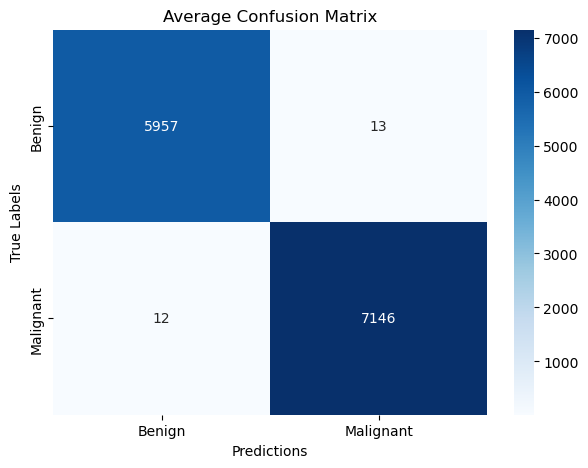

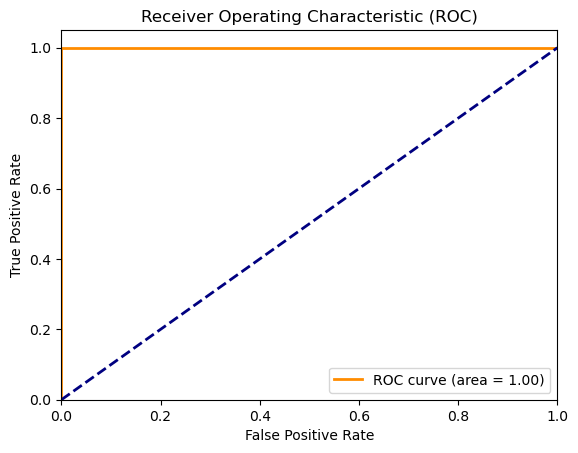

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

# Fonction de création du modèle CNN (inchangée)
def create_model(input_shape, conv_layers, dense_layers, filters, dense_units, learning_rate, dropout_rate):
    model = Sequential()
    
    # Ajouter des couches convolutionnelles
    for _ in range(conv_layers):
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Ajouter des couches denses
    for _ in range(dense_layers):
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Couche de sortie
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilateur
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Fonction d'optimisation des hyperparamètres avec Optuna (inchangée)
def optimize_hyperparameters(X, y):
    def objective(trial):
        # Définition des hyperparamètres (inchangée)
        conv_layers = trial.suggest_int("conv_layers", 1, 4)
        dense_layers = trial.suggest_int("dense_layers", 1, 3)
        filters = trial.suggest_categorical("filters", [32, 64, 128, 256])
        dense_units = trial.suggest_int("dense_units", 32, 256, step=32)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
        dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)

        # Cross-validation avec StratifiedKFold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        val_losses = []
        
        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Créer le modèle avec les paramètres actuels
            model = create_model(
                input_shape=(128, 128, 1),
                conv_layers=conv_layers,
                dense_layers=dense_layers,
                filters=filters,
                dense_units=dense_units,
                learning_rate=learning_rate,
                dropout_rate=dropout_rate
            )
            
            # Entraîner et évaluer le modèle
            early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
            history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
            val_losses.append(min(history.history["val_loss"]))

        return np.mean(val_losses)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=5)
    return study.best_params

# Meilleurs hyperparamètres trouvés par Optuna
best_params = optimize_hyperparameters(X, y)
print("Meilleurs hyperparamètres trouvés :", best_params)

# Créer le modèle avec les meilleurs hyperparamètres
best_model = create_model(input_shape=(128, 128, 1), **best_params)

# Diviser les données pour l'évaluation finale
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
classification_reports = []
confusion_matrices = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entraîner le modèle
    best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Prédictions
    y_pred_prob = best_model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calcul des métriques
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))
    metrics['roc_auc'].append(roc_auc_score(y_test, y_pred_prob))
    
    # Rapport de classification pour chaque itération
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(report)
    
    # Matrice de confusion pour chaque itération
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)

# Affichage des métriques moyennes
for metric, values in metrics.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f}")


# Calculate the average classification report across all folds
average_report = {
    'precision_0': np.mean([report['0']['precision'] for report in classification_reports]),
    'recall_0': np.mean([report['0']['recall'] for report in classification_reports]),
    'f1-score_0': np.mean([report['0']['f1-score'] for report in classification_reports]),
    'precision_1': np.mean([report['1']['precision'] for report in classification_reports]),
    'recall_1': np.mean([report['1']['recall'] for report in classification_reports]),
    'f1-score_1': np.mean([report['1']['f1-score'] for report in classification_reports])
}

# Display the average classification report
print("\nAverage Classification Report:")
print(f"Class 0 (Benign):")
print(f"  Precision: {average_report['precision_0']:.4f}")
print(f"  Recall: {average_report['recall_0']:.4f}")
print(f"  F1-Score: {average_report['f1-score_0']:.4f}")
print(f"Class 1 (Malignant):")
print(f"  Precision: {average_report['precision_1']:.4f}")
print(f"  Recall: {average_report['recall_1']:.4f}")
print(f"  F1-Score: {average_report['f1-score_1']:.4f}")


# Affichage de la matrice de confusion moyenne (somme de toutes les matrices de confusion)
average_conf_matrix = np.sum(confusion_matrices, axis=0)
print("\nMatrice de confusion moyenne :")
print(average_conf_matrix)

# Visualizing the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(average_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Average Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

# Courbe ROC pour la dernière itération
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % metrics['roc_auc'][-1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [23]:
%%time
result = sum(range(100000))

CPU times: total: 0 ns
Wall time: 2.02 ms


Accuracy: 0.9981
Precision: 0.9982
Recall: 0.9983
F1: 0.9983
Roc_auc: 0.9999

Average Classification Report:
Class 0 (Benign):
  Precision: 0.9980
  Recall: 0.9978
  F1-Score: 0.9979
Class 1 (Malignant):
  Precision: 0.9982
  Recall: 0.9983
  F1-Score: 0.9983

Matrice de confusion moyenne :
[[5957   13]
 [  12 7146]]


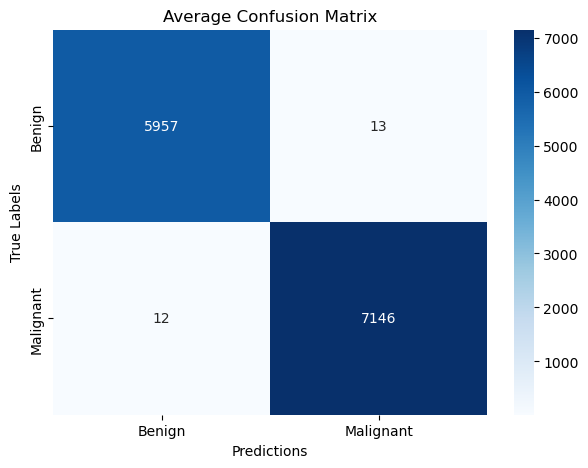

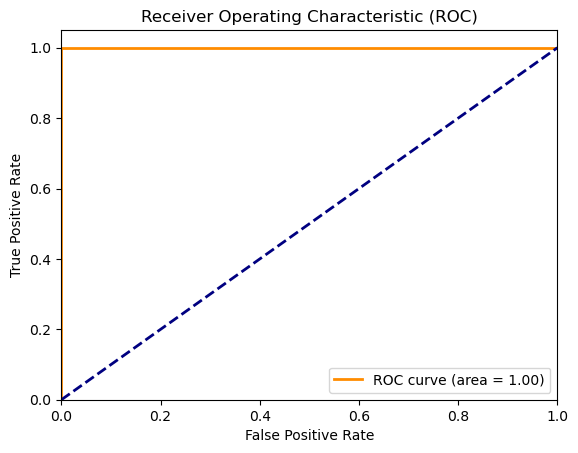

In [24]:
# Affichage des métriques moyennes
for metric, values in metrics.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f}")


# Calculate the average classification report across all folds
average_report = {
    'precision_0': np.mean([report['0']['precision'] for report in classification_reports]),
    'recall_0': np.mean([report['0']['recall'] for report in classification_reports]),
    'f1-score_0': np.mean([report['0']['f1-score'] for report in classification_reports]),
    'precision_1': np.mean([report['1']['precision'] for report in classification_reports]),
    'recall_1': np.mean([report['1']['recall'] for report in classification_reports]),
    'f1-score_1': np.mean([report['1']['f1-score'] for report in classification_reports])
}

# Display the average classification report
print("\nAverage Classification Report:")
print(f"Class 0 (Benign):")
print(f"  Precision: {average_report['precision_0']:.4f}")
print(f"  Recall: {average_report['recall_0']:.4f}")
print(f"  F1-Score: {average_report['f1-score_0']:.4f}")
print(f"Class 1 (Malignant):")
print(f"  Precision: {average_report['precision_1']:.4f}")
print(f"  Recall: {average_report['recall_1']:.4f}")
print(f"  F1-Score: {average_report['f1-score_1']:.4f}")


# Affichage de la matrice de confusion moyenne (somme de toutes les matrices de confusion)
average_conf_matrix = np.sum(confusion_matrices, axis=0)
print("\nMatrice de confusion moyenne :")
print(average_conf_matrix)

# Visualizing the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(average_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Average Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

# Courbe ROC pour la dernière itération
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % metrics['roc_auc'][-1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [28]:
%%time
# Code à mesurer
result = sum(range(100000))

CPU times: total: 15.6 ms
Wall time: 2.01 ms


[I 2024-12-28 17:52:47,706] A new study created in memory with name: no-name-4b65dc37-c0f4-4fb4-905e-432f67a91517
C:\Users\amal\AppData\Local\Temp\ipykernel_15884\602941779.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\amal\AppData\Local\Temp\ipykernel_15884\602941779.py:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
C:\Users\amal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer usi

Meilleurs hyperparamètres trouvés : {'conv_layers': 1, 'dense_layers': 3, 'filters': 128, 'dense_units': 256, 'learning_rate': 0.001168230485763112, 'dropout_rate': 0.32058646017269155}
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Fold 1:
Accuracy: 0.9954, Precision: 0.9965, Recall: 0.9951, F1-Score: 0.9958, ROC-AUC: 0.9999
Confusion Matrix:
[[1189    5]
 [   7 1425]]



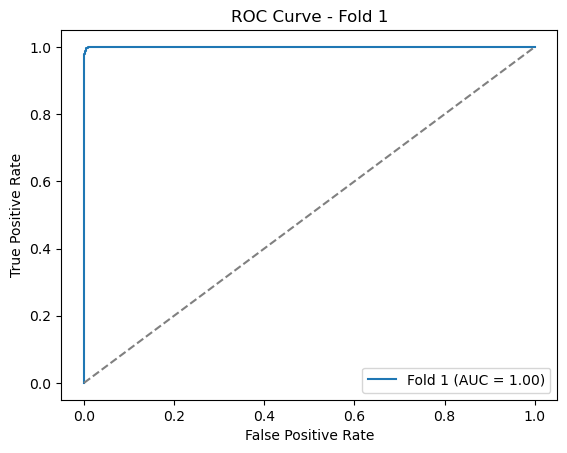

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Fold 2:
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, ROC-AUC: 1.0000
Confusion Matrix:
[[1194    0]
 [   0 1432]]



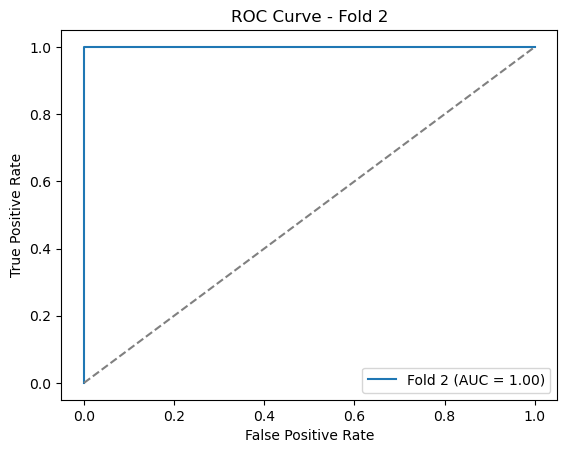

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Fold 3:
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, ROC-AUC: 1.0000
Confusion Matrix:
[[1194    0]
 [   0 1432]]



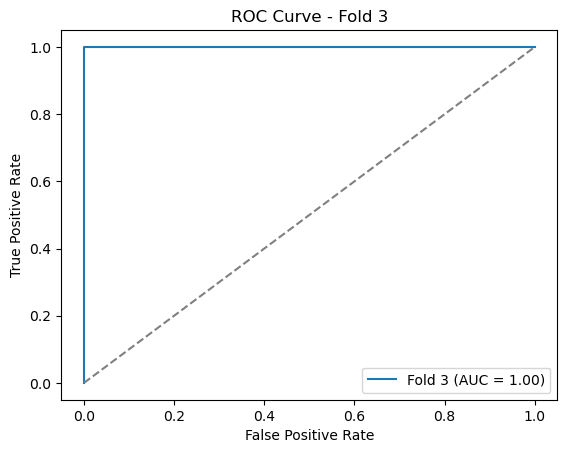

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Fold 4:
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, ROC-AUC: 1.0000
Confusion Matrix:
[[1194    0]
 [   0 1431]]



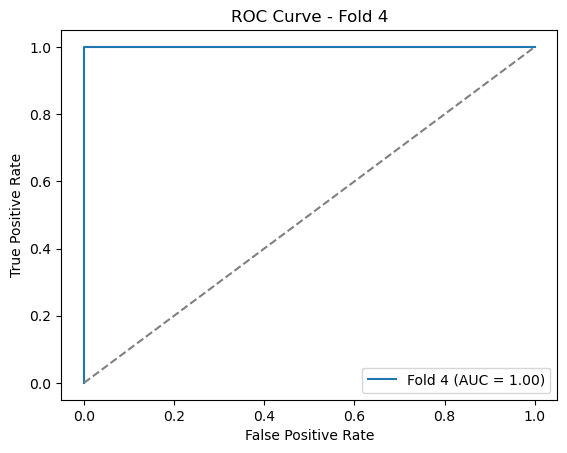

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Fold 5:
Accuracy: 0.9966, Precision: 0.9938, Recall: 1.0000, F1-Score: 0.9969, ROC-AUC: 1.0000
Confusion Matrix:
[[1185    9]
 [   0 1431]]



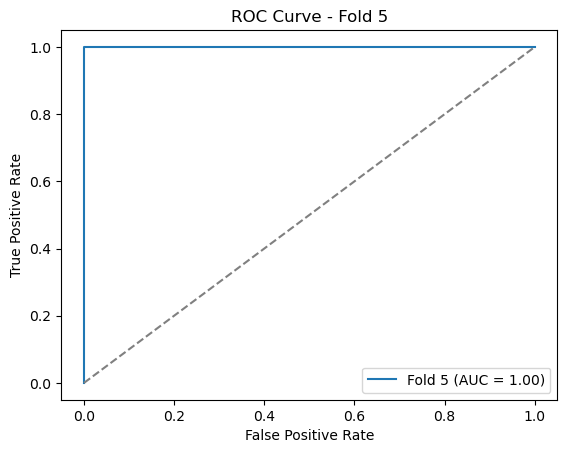

Accuracy: 0.9984
Precision: 0.9981
Recall: 0.9990
F1: 0.9985
Roc_auc: 1.0000

Average Classification Report:
Class 0 (Benign):
  Precision: 0.9980
  Recall: 0.9978
  F1-Score: 0.9979
Class 1 (Malignant):
  Precision: 0.9982
  Recall: 0.9983
  F1-Score: 0.9983

Matrice de confusion moyenne :
[[5956   14]
 [   7 7151]]


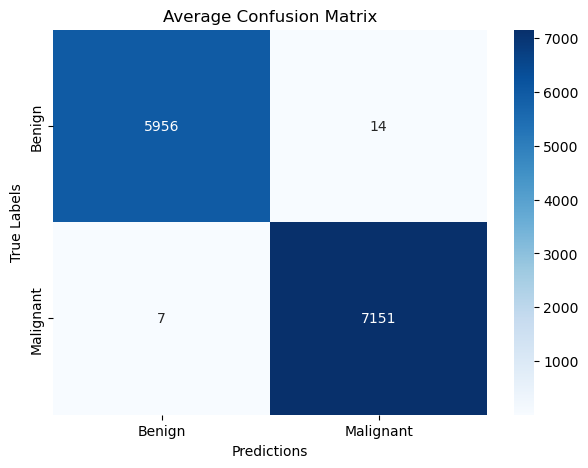

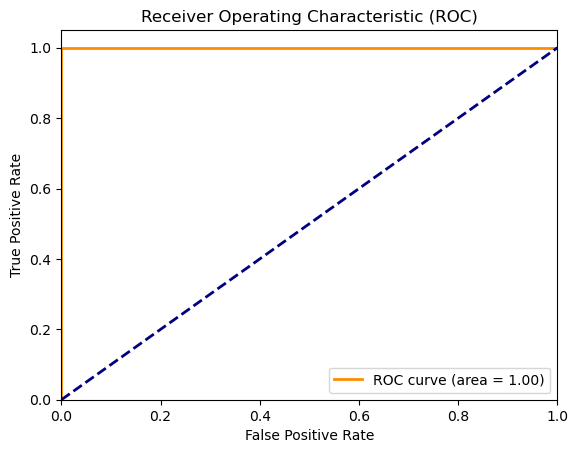

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fonction de création du modèle CNN
def create_model(input_shape, conv_layers, dense_layers, filters, dense_units, learning_rate, dropout_rate):
    model = Sequential()

    # Ajouter des couches convolutionnelles
    for _ in range(conv_layers):
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Ajouter des couches denses
    for _ in range(dense_layers):
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Couche de sortie
    model.add(Dense(1, activation='sigmoid'))

    # Compilateur
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Fonction d'optimisation des hyperparamètres avec Optuna
def optimize_hyperparameters(X, y):
    def objective(trial):
        conv_layers = trial.suggest_int("conv_layers", 1, 4)
        dense_layers = trial.suggest_int("dense_layers", 1, 3)
        filters = trial.suggest_categorical("filters", [32, 64, 128, 256])
        dense_units = trial.suggest_int("dense_units", 32, 256, step=32)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
        dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        val_losses = []

        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = create_model(
                input_shape=(128, 128, 1),
                conv_layers=conv_layers,
                dense_layers=dense_layers,
                filters=filters,
                dense_units=dense_units,
                learning_rate=learning_rate,
                dropout_rate=dropout_rate
            )

            early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
            history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
            val_losses.append(min(history.history["val_loss"]))

        return np.mean(val_losses)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=5)
    return study.best_params

# Meilleurs hyperparamètres trouvés par Optuna
best_params = optimize_hyperparameters(X, y)
print("Meilleurs hyperparamètres trouvés :", best_params)

# Créer le modèle avec les meilleurs hyperparamètres
best_model = create_model(input_shape=(128, 128, 1), **best_params)

# Validation croisée et affichage des résultats
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
confusion_matrices = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Entraîner le modèle
    best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Prédictions
    y_pred_prob = best_model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calcul des métriques
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    metrics['roc_auc'].append(roc_auc)

    # Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)

    # Affichage des résultats pour le fold actuel
    print(f"Fold {fold}:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")

    # Courbe ROC pour le fold actuel
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'ROC Curve - Fold {fold}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    fold += 1

# Affichage des métriques moyennes
for metric, values in metrics.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f}")


# Calculate the average classification report across all folds
average_report = {
    'precision_0': np.mean([report['0']['precision'] for report in classification_reports]),
    'recall_0': np.mean([report['0']['recall'] for report in classification_reports]),
    'f1-score_0': np.mean([report['0']['f1-score'] for report in classification_reports]),
    'precision_1': np.mean([report['1']['precision'] for report in classification_reports]),
    'recall_1': np.mean([report['1']['recall'] for report in classification_reports]),
    'f1-score_1': np.mean([report['1']['f1-score'] for report in classification_reports])
}

# Display the average classification report
print("\nAverage Classification Report:")
print(f"Class 0 (Benign):")
print(f"  Precision: {average_report['precision_0']:.4f}")
print(f"  Recall: {average_report['recall_0']:.4f}")
print(f"  F1-Score: {average_report['f1-score_0']:.4f}")
print(f"Class 1 (Malignant):")
print(f"  Precision: {average_report['precision_1']:.4f}")
print(f"  Recall: {average_report['recall_1']:.4f}")
print(f"  F1-Score: {average_report['f1-score_1']:.4f}")


# Affichage de la matrice de confusion moyenne (somme de toutes les matrices de confusion)
average_conf_matrix = np.sum(confusion_matrices, axis=0)
print("\nMatrice de confusion moyenne :")
print(average_conf_matrix)

# Visualizing the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(average_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Average Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

# Courbe ROC pour la dernière itération
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % metrics['roc_auc'][-1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [33]:
# Récupérer le numéro de la cellule précédente
previous_cell_number = len(In) - 2  # La cellule précédente est à l'index len(In) - 2

# Récupérer le code de la cellule précédente
previous_code = In[previous_cell_number]

# Exemple : Exécuter manuellement le code de la cellule précédente
exec(previous_code)


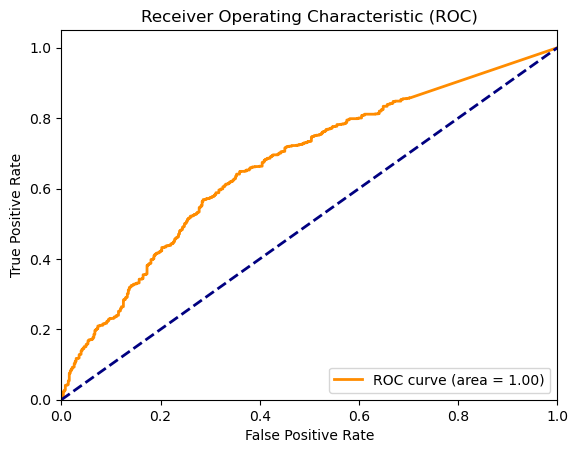

In [27]:
# Courbe ROC pour la dernière itération
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % metrics['roc_auc'][-1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [35]:
print (best_params)

{'learning_rate': 0.0001, 'batch_size': 32, 'dropout_rate1': 0.5, 'dropout_rate2': 0.3}


 ## ResNet 152 : avec Optuna + Cross Validation + Best params

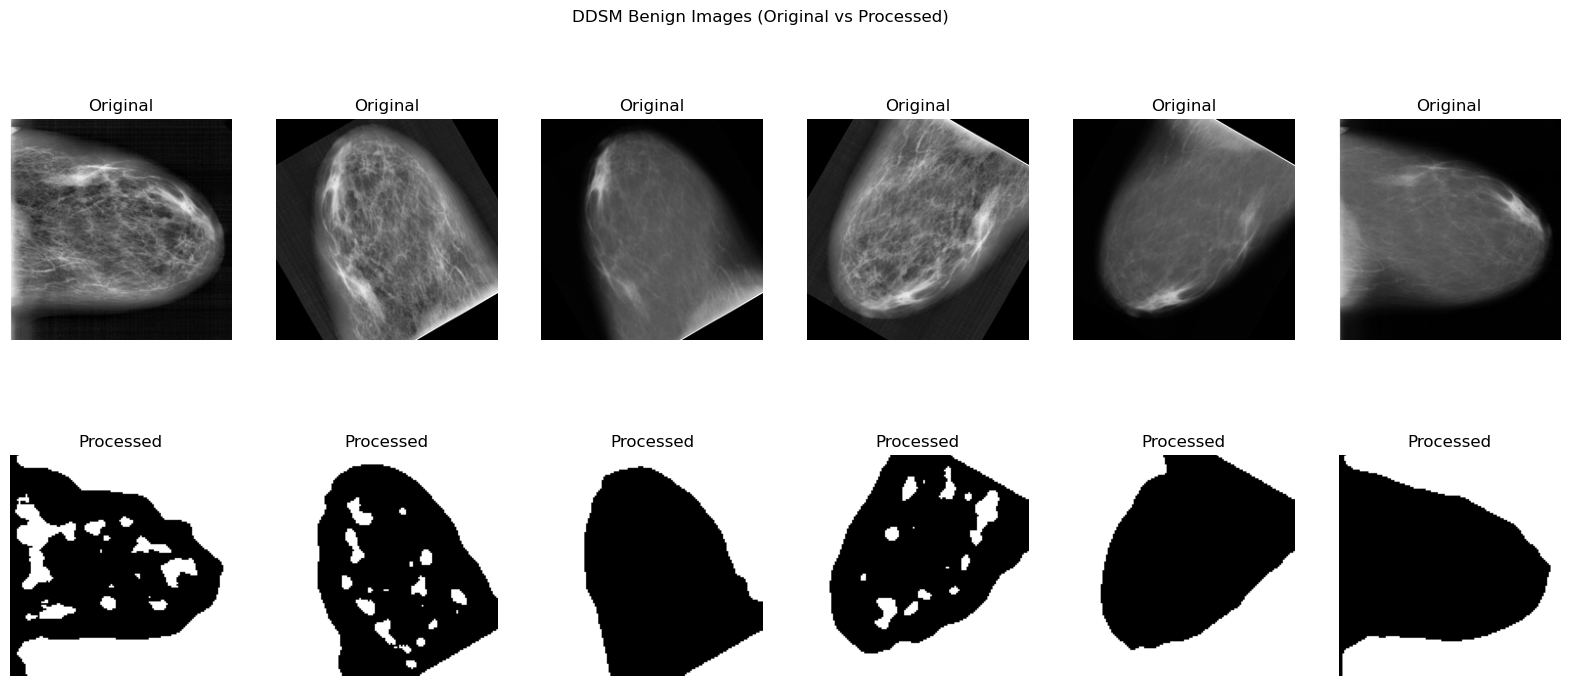

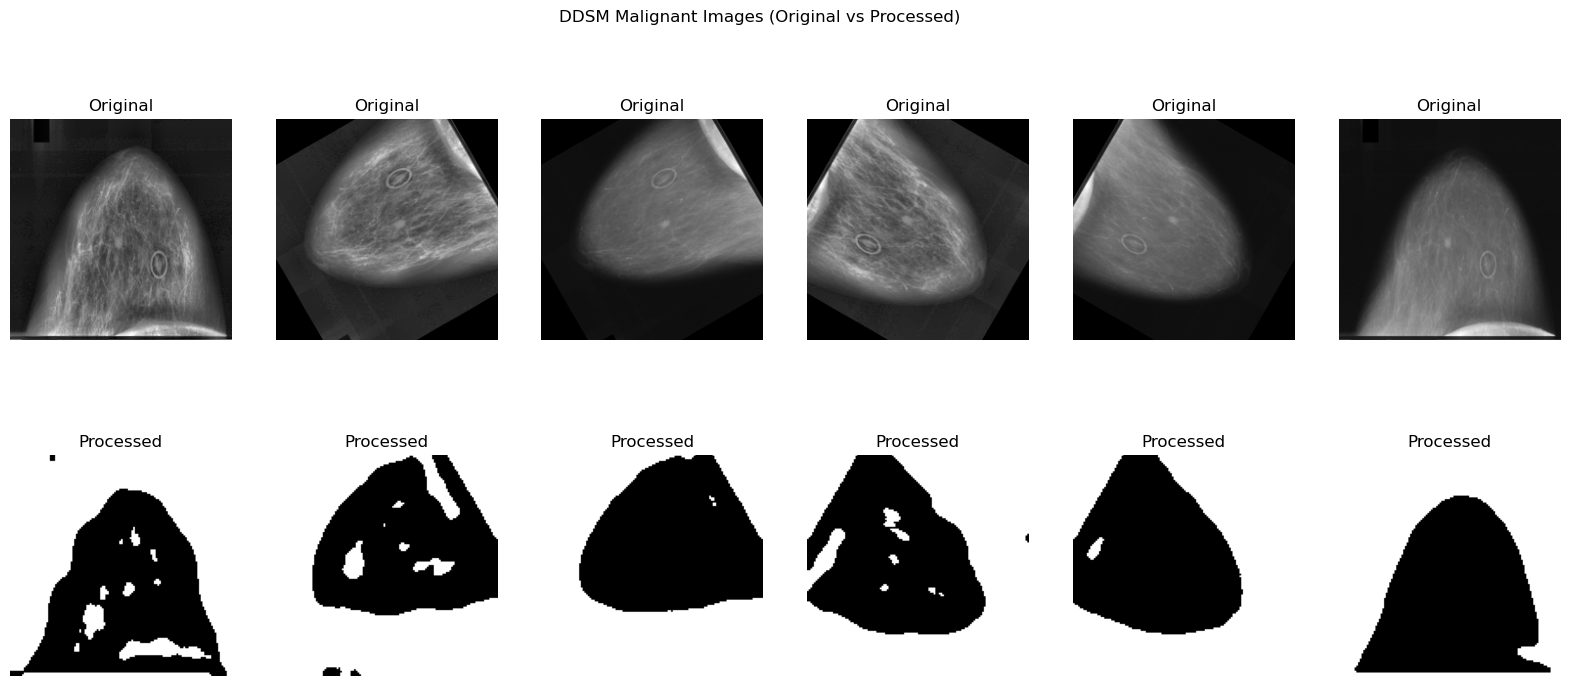

Combined Images Shape: (11940, 128, 128)
Combined Labels Shape: (11940,)

DDSM Benign: 5970
DDSM Malignant: 5970

Total images: 11940
Image shape: (128, 128)

Class distribution:
 [5970 5970]


In [73]:
# Function to load PNG images
def load_png_images(folder):                                   # Function Declaration
    images = []                                                # Initialize the images list
    for filename in os.listdir(folder):                        # Iterate over files in the directory
        img_path = os.path.join(folder, filename)              # Create the full file path
        if img_path.endswith('.png'):                          # Filter for PNG files (Yes / No)
            with Image.open(img_path) as img:                  # Open the PNG file
                for frame in range(img.n_frames):              # Iterate over GIF frames
                    img.seek(frame)                            # Select the current frame
                    frame_image = np.array(img.convert('L'))   # Convert to grayscale
                    images.append(frame_image)                 # Add the image to the list
    return images                                              # Return the list of images
    
# Function to resize images to a smaller size (e.g., 128x128)
def resize_images(images, target_size=(128, 128)):
    resized_images = []
    for img in images:
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA).astype(np.uint8)
        resized_images.append(img_resized)
    return np.array(resized_images)

# Function to preprocess images (with resizing)
def preprocess_images(images, target_size=(128, 128)):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    preprocessed_images = []
    
    for img in images:
        if img.ndim > 2:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Resize image to the target size (e.g., 128x128)
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA).astype(np.uint8)
        img_clahe = clahe.apply(img_resized)
        img_bright = cv2.convertScaleAbs(img_clahe, alpha=1, beta=30)
        img_denoised = cv2.medianBlur(img_bright, 5)
        _, img_segmented = cv2.threshold(img_denoised, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        img_normalized = img_segmented / 255.0
        
        preprocessed_images.append(img_normalized)
    
    return np.array(preprocessed_images)

# Function to load and preprocess images
def load_and_preprocess_images(folder, target_size=(128, 128)):
    images = load_png_images(folder)
    preprocessed_images = preprocess_images(images, target_size)
    return images, preprocessed_images

# Function to load and preprocess images
def display_images(images, processed_images=None, title="Images"):                # Function Declaration
    if len(images) == 0:                                                          
        print("Aucune image à afficher.") 
        return
    
    if processed_images is None:                                                  # Condition to display the original images
        fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
        fig.suptitle(title)
        for i, img in enumerate(images):
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
        plt.show()
    else:                                                                         #Condition to display the original and processed images
        fig, axes = plt.subplots(2, len(images), figsize=(20, 8)) 
        fig.suptitle(title)
        for i in range(len(images)):
            axes[0, i].imshow(images[i], cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Original')

            axes[1, i].imshow(processed_images[i], cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title('Processed')
        plt.show()
        
# Load and preprocess images (benign and malignant)
ddsm_benign_images, ddsm_benign_preprocessed = load_and_preprocess_images(ddsm_benign_dir, target_size=(128, 128))
ddsm_malignant_images, ddsm_malignant_preprocessed = load_and_preprocess_images(ddsm_malignant_dir, target_size=(128, 128))

# Display the first 6 original and preprocessed images for benign and malignant classes
display_images(ddsm_benign_images[:6], ddsm_benign_preprocessed[:6], "DDSM Benign Images (Original vs Processed)")
display_images(ddsm_malignant_images[:6], ddsm_malignant_preprocessed[:6], "DDSM Malignant Images (Original vs Processed)")

# Ensure both are numpy arrays before concatenation
ddsm_benign_preprocessed_array = np.array(ddsm_benign_preprocessed)
ddsm_malignant_preprocessed_array = np.array(ddsm_malignant_preprocessed)

# Now concatenate
all_images = np.concatenate((ddsm_benign_preprocessed_array, ddsm_malignant_preprocessed_array), axis=0)

# Create labels
ddsm_benign_labels = np.zeros(len(ddsm_benign_preprocessed_array), dtype=int)  # Benign label is 0
ddsm_malignant_labels = np.ones(len(ddsm_malignant_preprocessed_array), dtype=int)  # Malignant label is 1

# Assemble labels
all_labels = np.concatenate((ddsm_benign_labels, ddsm_malignant_labels), axis=0)

# Convert data to numpy arrays
X = np.array(all_images).reshape(-1, 128, 128, 1)  # Reshape to 128x128x1 for grayscale images
y = np.array(all_labels)

# Create a DataFrame for labels
df_labels = pd.DataFrame({'Label': y})

# Print combined arrays' shapes
print(f"Combined Images Shape: {all_images.shape}")
print(f"Combined Labels Shape: {all_labels.shape}")

# Split data into training and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print data summary
print(f"\nDDSM Benign: {len(ddsm_benign_images)}")
print(f"DDSM Malignant: {len(ddsm_malignant_images)}")
print(f"\nTotal images: {len(all_images)}")
print(f"Image shape: {X_train[0].shape}")

# Check class distribution
class_distribution = np.bincount(all_labels)
print("\nClass distribution:\n", class_distribution)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.6428 - loss: 2.5074 - val_accuracy: 0.6699 - val_loss: 0.6374
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.6770 - loss: 0.6320 - val_accuracy: 0.6699 - val_loss: 0.6344
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.6611 - loss: 0.6424 - val_accuracy: 0.6699 - val_loss: 0.6377
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.6713 - loss: 0.6326 - val_accuracy: 0.6699 - val_loss: 0.6349
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6636 - loss: 0.6317 - val_accuracy: 0.6699 - val_loss: 0.6239
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.6757 - loss: 0.6197 - val_accuracy: 0.6699 - val_loss: 0.6401
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.6713 - loss: 0.6111 - val_accuracy: 0.6699 - val_loss: 0.6352
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.6684 - loss: 0.6021 - val_accu

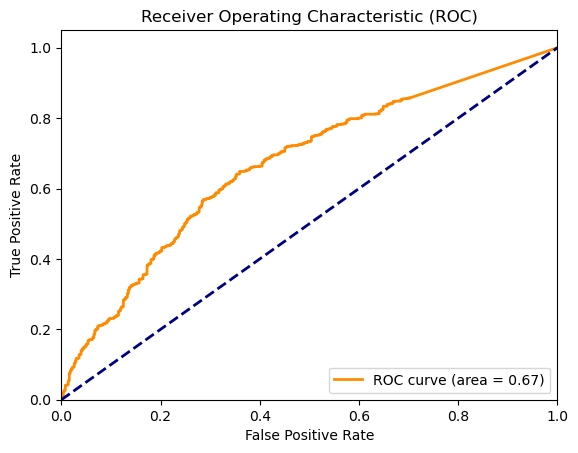

In [21]:
# Importations nécessaires
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

def create_resnet_model(hyperparameters):
    # Charger ResNet152 sans les poids préentraînés
    base_model = ResNet152(weights=None, include_top=False, input_shape=(128, 128, 3))
    
    # Ajouter des couches personnalisées pour l'adaptation à une classification binaire
    x = Flatten()(base_model.output)  # Aplatir les caractéristiques extraites
    x = Dense(128, activation='relu')(x)  # Couche dense intermédiaire
    output = Dense(1, activation='sigmoid')(x)  # Couche de sortie avec activation sigmoid
    
    # Créer le modèle final
    resnet_model = Model(inputs=base_model.input, outputs=output)
    
    # Compiler le modèle avec les hyperparamètres optimisés
    resnet_model.compile(
        optimizer=Adam(learning_rate=hyperparameters.get('learning_rate', 0.001)),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return resnet_model

# Conversion des images noir et blanc en format RGB
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

# Redimensionner les images à 128x128 (adapter selon les besoins)
X_train_rgb = np.resize(X_train_rgb, (X_train_rgb.shape[0], 128, 128, 3))
X_val_rgb = np.resize(X_val_rgb, (X_val_rgb.shape[0], 128, 128, 3))
X_test_rgb = np.resize(X_test_rgb, (X_test_rgb.shape[0], 128, 128, 3))

# Créer et entraîner le modèle ResNet152
resnet_model = create_resnet_model(best_params)

# Définir l'early stopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraîner le modèle
history = resnet_model.fit(
    X_train_rgb, y_train,  # Utiliser les données RGB
    epochs=10,  # Ajustez selon vos besoins
    batch_size=best_params.get('batch_size', 32),  # Utiliser batch_size s'il est optimisé
    validation_data=(X_val_rgb, y_val),  # Données de validation en RGB
    callbacks=[early_stopping]
)

# Évaluation finale sur l'ensemble de test
final_loss, final_accuracy = resnet_model.evaluate(X_test_rgb, y_test)  # Données de test en RGB
print(f"\nTest Loss: {final_loss:.4f}, Test Accuracy: {final_accuracy:.4f}")

# Prédictions sur le jeu de test
y_pred_prob = resnet_model.predict(X_test_rgb)  # Probabilités prédites
y_pred = (y_pred_prob > 0.5).astype(int)  # Conversion des probabilités en labels (0 ou 1)

# Calcul des métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Affichage des métriques d'évaluation
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Calcul de la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Affichage de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



Matrice de confusion moyenne :
[[2415  105]
 [  65 5047]]


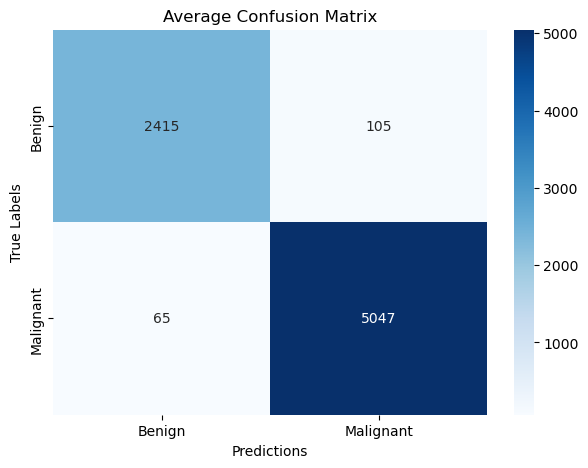

In [22]:
# Affichage de la matrice de confusion moyenne (somme de toutes les matrices de confusion)
average_conf_matrix = np.sum(confusion_matrices, axis=0)
print("\nMatrice de confusion moyenne :")
print(average_conf_matrix)

# Visualizing the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(average_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Average Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

## Fine Tunning ResNet152

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.4898 - loss: 2.1639 - val_accuracy: 0.4850 - val_loss: 0.6940
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5074 - loss: 0.9313 - val_accuracy: 0.5150 - val_loss: 0.6928
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.4853 - loss: 0.7099 - val_accuracy: 0.4850 - val_loss: 0.6934
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5094 - loss: 0.6936 - val_accuracy: 0.5150 - val_loss: 0.6931
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5475 - loss: 0.6942 - val_accuracy: 0.5150 - val_loss: 0.6931
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5199 - loss: 0.6930 - val_accuracy: 0.5150 - val_loss: 0.6930
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5287 - loss: 0.6930 - val_accuracy: 0.5150 - val_loss: 0.6930
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 630ms/step - accuracy: 0.5827 - loss: 0.6910

Test Loss: 0.6920, Test Accuracy: 0.5450
7/

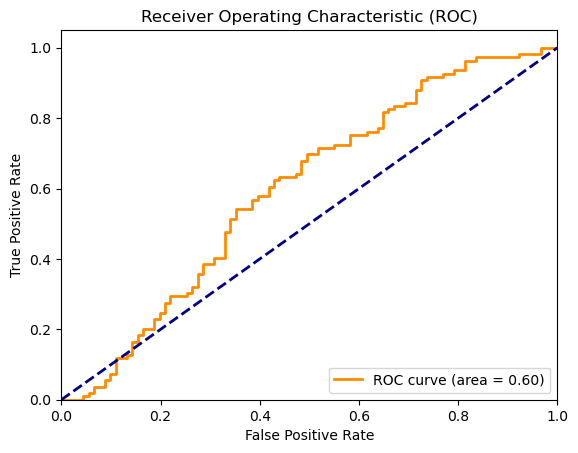

In [33]:
# Importations nécessaires
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

# Fonction pour créer le modèle ResNet152 avec Dropout et ReLU
def create_resnet_model(hyperparameters):
    # Charger ResNet152 sans les poids préentraînés
    base_model = ResNet152(weights=None, include_top=False, input_shape=(128, 128, 3))
    
    # Ajouter des couches personnalisées
    x = Flatten()(base_model.output)  # Aplatir les caractéristiques extraites
    x = Dense(256)(x)  # Couche dense avec 256 neurones
    x = Activation('relu')(x)  # Activation ReLU
    x = Dropout(hyperparameters.get('dropout_rate1', 0.5))(x)  # Dropout (par défaut 50%)
    
    x = Dense(128)(x)  # Couche dense avec 128 neurones
    x = Activation('relu')(x)  # Activation ReLU
    x = Dropout(hyperparameters.get('dropout_rate2', 0.3))(x)  # Dropout (par défaut 30%)
    
    # Couche de sortie
    output = Dense(1, activation='sigmoid')(x)  # Couche finale avec activation sigmoid pour une classification binaire
    
    # Créer le modèle final
    resnet_model = Model(inputs=base_model.input, outputs=output)
    
    # Compiler le modèle
    resnet_model.compile(
        optimizer=Adam(learning_rate=hyperparameters.get('learning_rate', 0.001)),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return resnet_model

# Conversion des images noir et blanc en format RGB
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

# Redimensionner les images à 128x128
X_train_rgb = np.resize(X_train_rgb, (X_train_rgb.shape[0], 128, 128, 3))
X_val_rgb = np.resize(X_val_rgb, (X_val_rgb.shape[0], 128, 128, 3))
X_test_rgb = np.resize(X_test_rgb, (X_test_rgb.shape[0], 128, 128, 3))

# Définir les hyperparamètres optimisés
best_params = {
    'learning_rate': 0.0001,
    'batch_size': 32,
    'dropout_rate1': 0.5,
    'dropout_rate2': 0.3
}

# Créer et entraîner le modèle ResNet152
resnet_model = create_resnet_model(best_params)

# Définir l'early stopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraîner le modèle
history = resnet_model.fit(
    X_train_rgb, y_train,  # Utiliser les données RGB
    epochs=10,  # Ajustez selon vos besoins
    batch_size=best_params['batch_size'],  # Utiliser batch_size s'il est optimisé
    validation_data=(X_val_rgb, y_val),  # Données de validation en RGB
    callbacks=[early_stopping]
)

# Évaluation finale sur l'ensemble de test
final_loss, final_accuracy = resnet_model.evaluate(X_test_rgb, y_test)  # Données de test en RGB
print(f"\nTest Loss: {final_loss:.4f}, Test Accuracy: {final_accuracy:.4f}")

# Prédictions sur le jeu de test
y_pred_prob = resnet_model.predict(X_test_rgb)  # Probabilités prédites
y_pred = (y_pred_prob > 0.5).astype(int)  # Conversion des probabilités en labels (0 ou 1)

# Calcul des métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Affichage des métriques d'évaluation
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Calcul de la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Affichage de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Affichage des métriques moyennes
for metric, values in metrics.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f}")

# Calcul du rapport de classification moyen pour les deux classes
average_report = {
    'precision_0': np.mean([report['0']['precision'] for report in classification_reports]),
    'recall_0': np.mean([report['0']['recall'] for report in classification_reports]),
    'f1-score_0': np.mean([report['0']['f1-score'] for report in classification_reports]),
    'precision_1': np.mean([report['1']['precision'] for report in classification_reports]),
    'recall_1': np.mean([report['1']['recall'] for report in classification_reports]),
    'f1-score_1': np.mean([report['1']['f1-score'] for report in classification_reports])
}

print("\nRapport de classification moyen :")
print(f"Classe 0 (Bénins):")
print(f"  Précision : {average_report['precision_0']:.4f}")
print(f"  Rappel : {average_report['recall_0']:.4f}")
print(f"  F1-Score : {average_report['f1-score_0']:.4f}")
print(f"Classe 1 (Malins):")
print(f"  Précision : {average_report['precision_1']:.4f}")
print(f"  Rappel : {average_report['recall_1']:.4f}")
print(f"  F1-Score : {average_report['f1-score_1']:.4f}")

# Affichage de la matrice de confusion moyenne (somme de toutes les matrices de confusion)
average_conf_matrix = np.sum(confusion_matrices, axis=0)
print("\nMatrice de confusion moyenne :")
print(average_conf_matrix)

# Courbe ROC pour la dernière itération
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % metrics['roc_auc'][-1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()